# Emission Measure

In [1]:
import sys

import numpy as np
from scipy.interpolate import splev
import matplotlib.pyplot as plt
from sunpy.map import Map
import astropy.units as u
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.analysis import DistributedAIACollection,DistributedAIACube
from synthesizAR.analysis.dem import EMCube

sys.path.append('../scripts/')
from dem import HannahKontarModel

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [2]:
cluster = distributed.LocalCluster(n_workers=32,threads_per_worker=2)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:44954 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 64 Memory: 270.38 GB


First, read in the model and observational data. For now, we'll just take a time-average. It may be better to time-average in chunks though still not completely sure about that...

In [3]:
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_201102*_{}_cutout.fits'

In [4]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [5]:
cube = DistributedAIACollection(*[DistributedAIACube.from_files(read_template.format(c['name'])) for c in aia.channels])

Next, set up the temperature bins.

In [6]:
temperature_bin_edges = 10.**np.arange(5.5,7.3,0.1) * u.K
temperature_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.

And calculate the instrument responses.

In [7]:
responses = [splev(temperature_bin_centers.value, c['temperature_response_spline']) for c in aia.channels]

Next, we'll time-average the emission in each channel

In [8]:
maps = [cube[c['name']].average(chunks=(cube[c['name']].shape[0],
                                        cube[c['name']].shape[1]//5,
                                        cube[c['name']].shape[2]//5)) 
        for c in aia.channels]

and normalize each map to the exposure time

In [12]:
maps = [Map(m.data/m.exposure_time.value, m.meta) for m in maps]

And finally compute the EM distribution using the method of HK12 in IDL.

In [13]:
hk_model = HannahKontarModel(
    maps,
    temperature_bin_edges,
    responses,
    dem_path='/storage-home/w/wtb2/codes/demreg/idl/'
)

In [14]:
em = hk_model.fit(
    alpha=1,
    increase_alpha=1.1,
    verbose=False,
    n_sample=len(cube[0].maps)
)

Now, compute the emission measure slope in each pixel by fitting over the interval $[10^6,T_{peak}]$, where $T_{peak}$ is the temperature at the peak of the emission measure distribution.

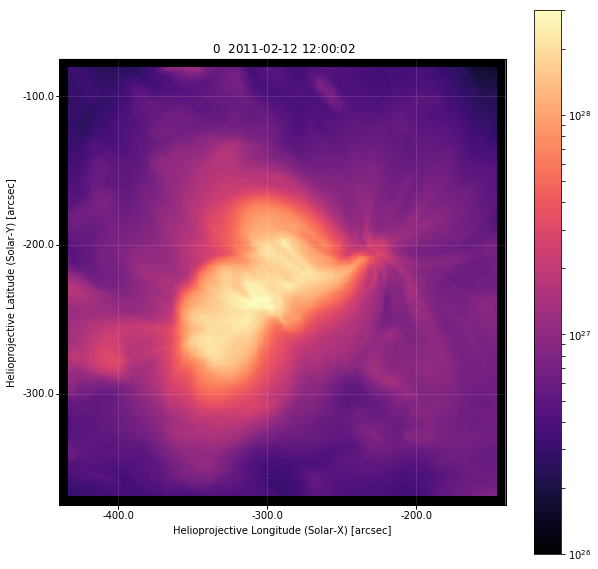

In [15]:
em_total = em.total_emission
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=em_total)
em_total.plot(axes=ax,vmin=1e26,vmax=3e28)
plt.colorbar()

In [16]:
del em[0].meta['keycomments']
em.save('../paper/data/observations/em_cube.h5')